## **Problem Description**

Financial institutions that lend to consumers rely on models to help decide on who to approve or decline for credit (for lending products such as credit cards, automobile loans, or home loans). In this project, your task is to develop models that review credit card applications to determine which ones should be approved. You are given historical data on response (binary default indicator) and 20 predictor variables from credit card accounts for a hypothetical bank XYZ, a regional bank in the Bay area. There are three datasets available: a [training](https://raw.githubusercontent.com/rbv98/Credit-Card-Application-review/main/Train.csv) dataset with 20,000 accounts; a [validation](https://raw.githubusercontent.com/rbv98/Credit-Card-Application-review/main/Validation.csv) dataset with 3,000 accounts, and a **hidden** test dataset with 5,000 accounts. Information about the variables is given in the [Appendix](https://github.com/rbv98/Credit-Card-Application-review/blob/main/appendix.pdf).


In [3]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

training_df=pd.read_csv('https://raw.githubusercontent.com/rbv98/Credit-Card-Application-review/main/Train.csv')
validation_df= pd.read_csv('https://raw.githubusercontent.com/rbv98/Credit-Card-Application-review/main/Validation.csv')

## EDA & Pre-processing

In [4]:
training_df.head()

,tot_credit_debt,avg_card_debt,credit_age,credit_good_age,card_age,non_mtg_acc_past_due_12_months_num,non_mtg_acc_past_due_6_months_num,mortgages_past_due_6_months_num,credit_past_due_amount,inq_12_month_num,...,card_open_36_month_num,auto_open_ 36_month_num,uti_card,uti_50plus_pct,uti_max_credit_line,uti_card_50plus_pct,ind_acc_XYZ,rep_income,States,Default_ind
0,80826.71,15872.99,300.0,114.0,292.0,0.0,0.0,0.0,0.00,3.0,...,0.0,0.0,0.365902,0.475594,0.410504,NaN,0.0,69000.0,AL,0.0
1,96052.60,12178.02,281.0,102.0,232.0,0.0,0.0,0.0,0.00,2.0,...,1.0,0.0,0.542786,0.543158,0.535147,0.587351,0.0,61000.0,FL,0.0
2,75212.76,12052.24,261.0,149.0,260.0,0.0,0.0,0.0,0.00,1.0,...,0.0,1.0,0.323678,0.321776,0.348713,0.413293,0.0,NaN,AL,0.0
3,70727.84,8416.80,227.0,93.0,223.0,2.0,1.0,1.0,11013.96,0.0,...,1.0,0.0,0.448721,0.422809,0.491365,0.466810,0.0,79000.0,SC,1.0
4,41604.47,10611.97,249.0,136.0,241.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.644030,0.619987,0.546655,0.588442,1.0,NaN,LA,0.0


In [5]:
training_df.describe()

,tot_credit_debt,avg_card_debt,credit_age,credit_good_age,card_age,non_mtg_acc_past_due_12_months_num,non_mtg_acc_past_due_6_months_num,mortgages_past_due_6_months_num,credit_past_due_amount,inq_12_month_num,card_inq_24_month_num,card_open_36_month_num,auto_open_ 36_month_num,uti_card,uti_50plus_pct,uti_max_credit_line,uti_card_50plus_pct,ind_acc_XYZ,rep_income,Default_ind
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,17945.000000,20000.000000,18430.000000,20000.000000
mean,94563.702530,14088.235475,296.697000,149.771750,268.015200,0.11135,0.027400,0.030200,329.287867,1.762700,3.409600,0.163050,0.141000,0.503157,0.511007,0.507629,0.489594,0.258550,75499.511666,0.079300
std,23546.443862,9314.495936,61.711702,34.016476,59.364769,0.43389,0.171903,0.171142,2073.899357,1.740816,2.926697,0.386099,0.349607,0.109354,0.113456,0.108624,0.119701,0.437849,16361.955146,0.270213
min,2367.430000,2363.120000,54.000000,21.000000,41.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065120,0.033749,0.005174,0.000000,0.000000,12000.000000,0.000000
25%,78743.750000,11321.502500,255.000000,127.000000,227.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.429611,0.435171,0.433550,0.409794,0.000000,64000.000000,0.000000
50%,94670.630000,13243.750000,297.000000,150.000000,268.000000,0.00000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.502800,0.509922,0.507193,0.490074,0.000000,75000.000000,0.000000
75%,110329.335000,15196.060000,339.000000,172.000000,308.000000,0.00000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,0.000000,0.577412,0.588418,0.581376,0.569036,1.000000,86000.000000,0.000000
max,188890.960000,99999.000000,545.000000,296.000000,520.000000,4.00000,2.000000,1.000000,32662.980000,10.000000,18.000000,2.000000,2.000000,0.969289,0.988964,1.000000,0.970776,1.000000,150000.000000,1.000000


In [6]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   tot_credit_debt                     20000 non-null  float64
 1   avg_card_debt                       20000 non-null  float64
 2   credit_age                          20000 non-null  float64
 3   credit_good_age                     20000 non-null  float64
 4   card_age                            20000 non-null  float64
 5   non_mtg_acc_past_due_12_months_num  20000 non-null  float64
 6   non_mtg_acc_past_due_6_months_num   20000 non-null  float64
 7   mortgages_past_due_6_months_num     20000 non-null  float64
 8   credit_past_due_amount              20000 non-null  float64
 9   inq_12_month_num                    20000 non-null  float64
 10  card_inq_24_month_num               20000 non-null  float64
 11  card_open_36_month_num              20000

In [7]:
training_df.isnull().sum()

tot_credit_debt                          0
avg_card_debt                            0
credit_age                               0
credit_good_age                          0
card_age                                 0
non_mtg_acc_past_due_12_months_num       0
non_mtg_acc_past_due_6_months_num        0
mortgages_past_due_6_months_num          0
credit_past_due_amount                   0
inq_12_month_num                         0
card_inq_24_month_num                    0
card_open_36_month_num                   0
auto_open_ 36_month_num                  0
uti_card                                 0
uti_50plus_pct                           0
uti_max_credit_line                      0
uti_card_50plus_pct                   2055
ind_acc_XYZ                              0
rep_income                            1570
States                                   0
Default_ind                              0
dtype: int64

### Handling missing values
Columns with missing values are 'uti_card_50plus_pct' with 2055 and 'rep_income' with 1570.


The histograms show the distributions of uti_card_50plus_pct and rep_income in both the training and validation datasets.The distribution in both datasets appears to be relatively smooth.
A common imputation strategy for such cases is using the mean.

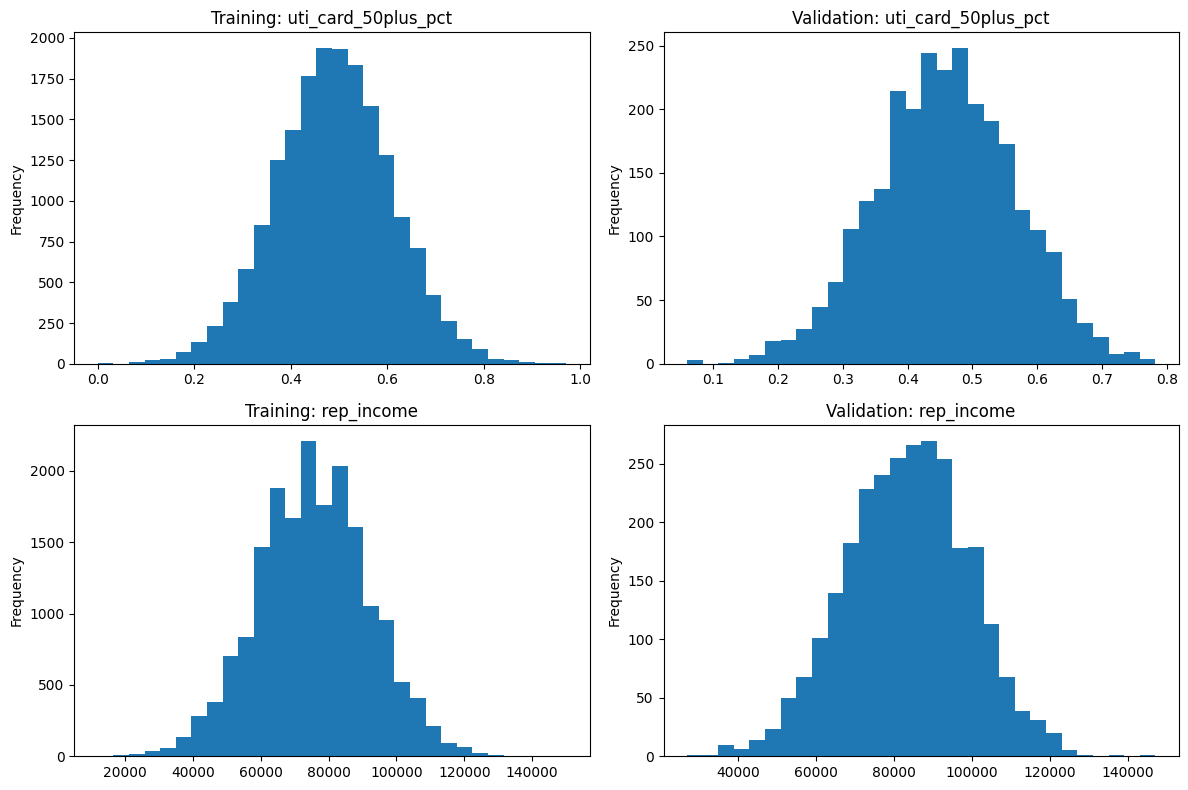

In [8]:
import matplotlib.pyplot as plt

# Plotting the distributions of the variables with missing values
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Distribution of 'uti_card_50plus_pct' in the training dataset
training_df['uti_card_50plus_pct'].plot(kind='hist', bins=30, ax=ax[0, 0], title="Training: uti_card_50plus_pct")

# Distribution of 'uti_card_50plus_pct' in the validation dataset
validation_df['uti_card_50plus_pct'].plot(kind='hist', bins=30, ax=ax[0, 1], title="Validation: uti_card_50plus_pct")

# Distribution of 'rep_income' in the training dataset
training_df['rep_income'].plot(kind='hist', bins=30, ax=ax[1, 0], title="Training: rep_income")

# Distribution of 'rep_income' in the validation dataset
validation_df['rep_income'].plot(kind='hist', bins=30, ax=ax[1, 1], title="Validation: rep_income")

plt.tight_layout()
plt.show()


In [9]:
imputer_uti = SimpleImputer(strategy='mean')
imputer_income = SimpleImputer(strategy='mean')

# Imputation for 'uti_card_50plus_pct'
training_df['uti_card_50plus_pct'] = imputer_uti.fit_transform(training_df[['uti_card_50plus_pct']])
validation_df['uti_card_50plus_pct'] = imputer_uti.transform(validation_df[['uti_card_50plus_pct']])

# Imputation for 'rep_income'
training_df['rep_income'] = imputer_income.fit_transform(training_df[['rep_income']])
validation_df['rep_income'] = imputer_income.transform(validation_df[['rep_income']])


### Feature selection
The data is then split into ‘Y’ which is the target variable containing the feature ‘Default_ind’ and ‘X’ which contains all the other features for both training and validation data.

The 'States' feature is dropped as we assume that the geographical information should not affect the outcome.

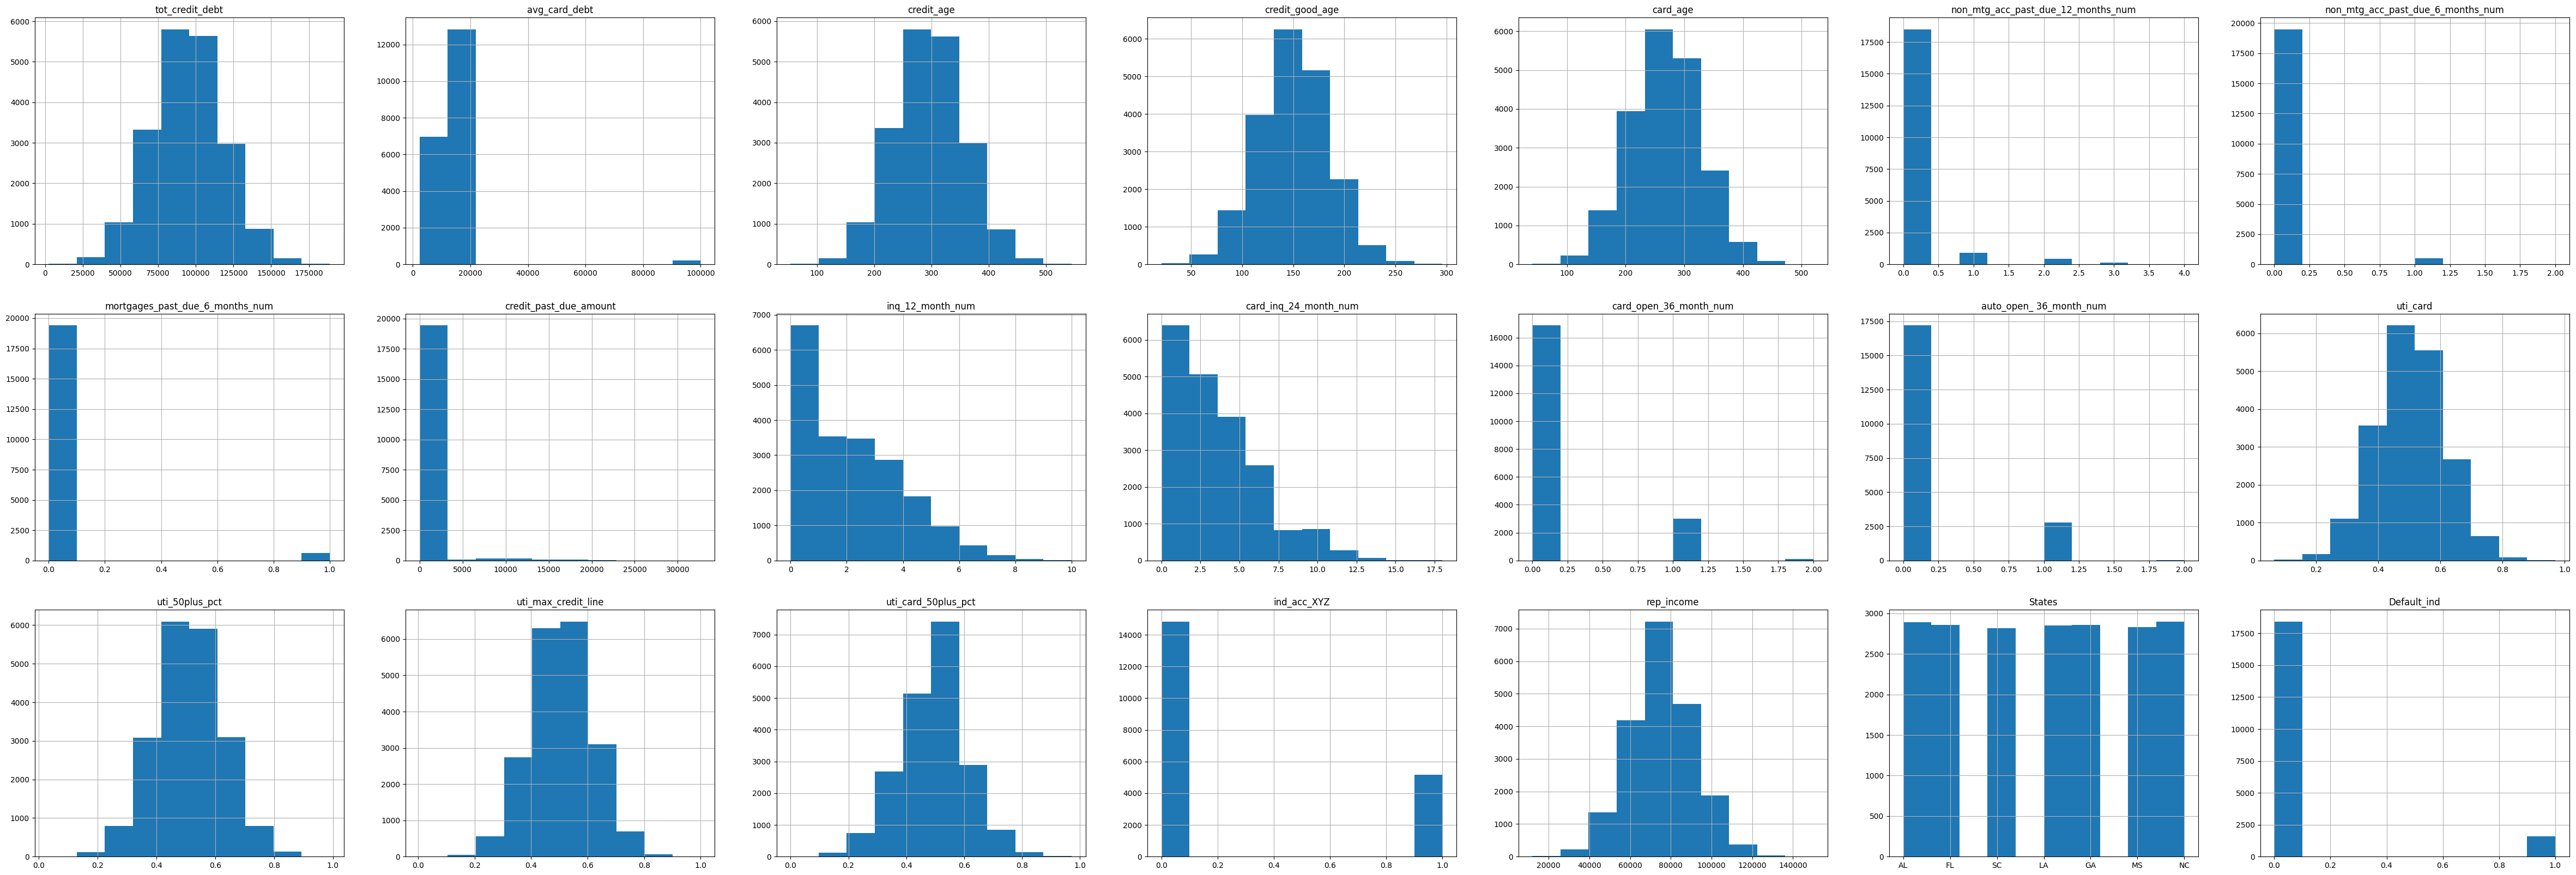

In [10]:
#Distribution
plt.rcParams['figure.figsize']= (60,20)
a=1
for i in training_df.columns:
  plt.subplot(3,7,a)
  plt.title(f"{i}")
  training_df[i].hist()
  a+=1
plt.show()

In [11]:
X_train_original = training_df.drop(['Default_ind','States'], axis=1)
y_train_original = training_df['Default_ind']
X_validation_original = validation_df.drop(['Default_ind', 'States'], axis=1)
y_validation_original = validation_df['Default_ind']


## Checking the imbalanced data

In [12]:
y_train_original.value_counts()

0.0    18414
1.0     1586
Name: Default_ind, dtype: int64

We can see that the data is imbalanced by the count of default and non default. This is not ideal for a logistic regression model. We will proceed by fitting the processed data with a baseline logistic regression model first and then compare its performance with other models such as Random forest and XG-Boost.

In [13]:

scaler = StandardScaler()

# standardizing the data
X_train_original_scaled = scaler.fit_transform(X_train_original)
X_validation_original_scaled = scaler.transform(X_validation_original)


## Model fitting

### Baseline logistic regression model

Classification Report for Logistic Regression Model:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      2778
         1.0       0.71      0.30      0.42       222

    accuracy                           0.94      3000
   macro avg       0.83      0.65      0.70      3000
weighted avg       0.93      0.94      0.93      3000

AUC:  0.8171086853592253


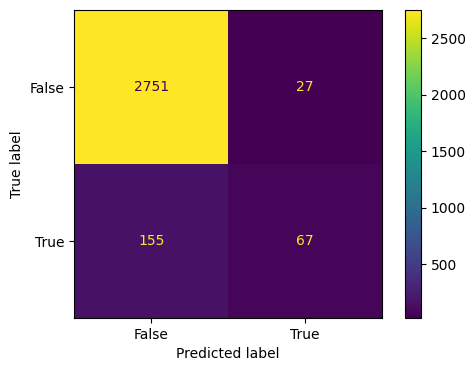

In [14]:

lr_model = LogisticRegression()
lr_model.fit(X_train_original_scaled, y_train_original)

# Predicting on the validation set
y_pred = lr_model.predict(X_validation_original_scaled)

# Assessing the model's performance
classification_rep = classification_report(y_validation_original, y_pred)
confusion_mat = confusion_matrix(y_validation_original, y_pred)

print("Classification Report for Logistic Regression Model:\n")
print(classification_rep)

# Predict probabilities for the validation set
y_pred_proba_lr = lr_model.predict_proba(X_validation_original_scaled)[:,1]

# Calculate ROC Curve and AUC for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_validation_original, y_pred_proba_lr)
auc_lr = auc(fpr_lr, tpr_lr)

print('AUC: ',auc_lr)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = [False, True])
fig, ax = plt.subplots(figsize=(6, 4))
cm_display.plot(ax=ax)
plt.show()

### Random Forest model

Classification Report for Random Forest Model:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      2778
         1.0       0.76      0.29      0.42       222

    accuracy                           0.94      3000
   macro avg       0.86      0.64      0.70      3000
weighted avg       0.93      0.94      0.93      3000

AUC:  0.8505389839083143


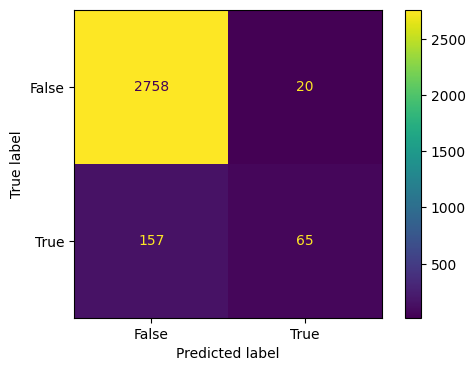

In [15]:
# Creating and fitting the Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, random_state=123, class_weight={0:10, 1:0.8})
rf_model.fit(X_train_original_scaled, y_train_original)


y_pred_rf = rf_model.predict(X_validation_original_scaled)
classification_rep_rf = classification_report(y_validation_original, y_pred_rf)
confusion_mat = confusion_matrix(y_validation_original, y_pred_rf)
print("Classification Report for Random Forest Model:\n")
print(classification_rep_rf)

y_pred_proba_rf = rf_model.predict_proba(X_validation_original_scaled)[:,1]


fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_validation_original, y_pred_proba_rf)
auc_rf = auc(fpr_rf, tpr_rf)

print('AUC: ',auc_rf)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = [False, True])
fig, ax = plt.subplots(figsize=(6, 4))
cm_display.plot(ax=ax)
plt.show()

## XG Boost model

Classification Report for XG-Boost Model:

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      2778
         1.0       0.49      0.59      0.53       222

    accuracy                           0.92      3000
   macro avg       0.73      0.77      0.74      3000
weighted avg       0.93      0.92      0.93      3000

AUC:  0.875229441104171


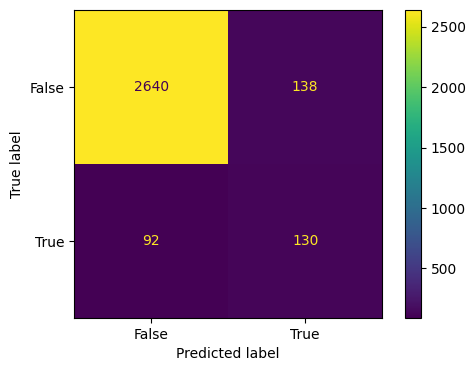

In [16]:

xgb_model = XGBClassifier(
    objective='binary:logistic',random_state=123,scale_pos_weight= 5,max_depth=2,eval_metric='logloss',enable_categorical= 'missing')
xgb_model.fit(X_train_original_scaled, y_train_original)

# Predicting on the validation set
y_pred_xgb = xgb_model.predict(X_validation_original_scaled)

# Assessing the model's performance
classification_rep_xgb = classification_report(y_validation_original, y_pred_xgb)
confusion_mat = confusion_matrix(y_validation_original, y_pred_xgb)
print("Classification Report for XG-Boost Model:\n")
print(classification_rep_xgb)

y_pred_proba_xgb = xgb_model.predict_proba(X_validation_original_scaled)[:,1]


fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_validation_original, y_pred_proba_xgb)
auc_xg = auc(fpr_xg, tpr_xg)

print('AUC: ',auc_xg)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = [False, True])
fig, ax = plt.subplots(figsize=(6, 4))
cm_display.plot(ax=ax)
plt.show()

|Model|Precision|Recall|F1-Score|Accuracy|AUC|
|----------|----------|----------|----------|----------|----------|
|Logisitic Regression|0.71|0.30|0.42|0.94|0.82
|Random Forest|0.76|0.29|0.42|0.94|0.85
|XGBoost|0.49|0.59|0.53|0.92|0.87

# Best model : **XG Boost model**
With the highest F1-score, XG-Boost appears to be the optimal model for both optimizing the identification of defaulters (high recall) and upholding a favorable balance between precision and recall. Additionally, it performs better overall, as seen by its greatest AUC

### Feature importance

The ‘ind_acc_XYZ’ feature, which represents whether a customer already has an account with the financial institution, has a high importance score in the XG-Boost model. This indicates that the feature is a significant predictor within the model. The feature is positively associated with the probability of credit approval, indicating that the model might be giving favourable treatment to existing customers.

In [17]:
feature_importances = xgb_model.feature_importances_
feature_names = X_train_original.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df_sorted = importance_df.sort_values(by='Importance', ascending=False)

# Check the importance of 'ind_acc_XYZ'
print(importance_df_sorted)


                               Feature  Importance
7      mortgages_past_due_6_months_num    0.820418
5   non_mtg_acc_past_due_12_months_num    0.053842
13                            uti_card    0.030564
1                        avg_card_debt    0.026785
2                           credit_age    0.009951
9                     inq_12_month_num    0.008944
4                             card_age    0.008399
17                         ind_acc_XYZ    0.008183
6    non_mtg_acc_past_due_6_months_num    0.007770
0                      tot_credit_debt    0.004320
3                      credit_good_age    0.003370
14                      uti_50plus_pct    0.003100
15                 uti_max_credit_line    0.002748
16                 uti_card_50plus_pct    0.002708
10               card_inq_24_month_num    0.002603
11              card_open_36_month_num    0.002211
8               credit_past_due_amount    0.002159
18                          rep_income    0.001925
12             auto_open_ 36_mo